In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize': (20, 10)})

## Load and explore data

In [2]:
# import csv file containing fleet information
fleet_df = pd.read_csv('ac_fleet.csv')
fleet_df

,Model,Identifier,Cruise Speed (km/h),Range (km),Cruise Altitude (m),Cargo Capacity (kg),Total Seats
0,Boeing 777-300ER,77W,896,14594,10668,23024,450
1,Boeing 777-200LR,77L,896,17446,10668,15300,300
2,Airbus A330-300,333,869,10560,11277,13900,292
3,Boeing 787-9,789,913,15370,11887,15100,298
4,Boeing 787-8,788,913,14500,11887,14100,255
5,Boeing 767-300ER,763,853,10549,11277,11600,211
6,Airbus A321-200,321,837,4350,10668,3600,190
7,Airbus A320-200,320,837,4442,10668,2000,146
8,Airbus A319-100,319,837,4442,10668,2000,120
9,Embraer 190,E90,811,3540,10668,1502,97


In [3]:
# check for missing data
print('Number of Missing Entries by Column')
fleet_df.isnull().sum()

Number of Missing Entries by Column


Model                  0
Identifier             0
Cruise Speed (km/h)    0
Range (km)             0
Cruise Altitude (m)    0
Cargo Capacity (kg)    0
Total Seats            0
dtype: int64

In [4]:
# check data types
fleet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Model                16 non-null     object
 1   Identifier           16 non-null     object
 2   Cruise Speed (km/h)  16 non-null     int64 
 3   Range (km)           16 non-null     int64 
 4   Cruise Altitude (m)  16 non-null     int64 
 5   Cargo Capacity (kg)  16 non-null     int64 
 6   Total Seats          16 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 1.0+ KB


In [5]:
# numerical statistics
fleet_df.describe()

,Cruise Speed (km/h),Range (km),Cruise Altitude (m),Cargo Capacity (kg),Total Seats
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,806.437500,6960.687500,10401.187500,6914.250000,170.375000
std,129.336238,5809.942406,1459.030144,7262.723406,120.250225
min,491.000000,1295.000000,7620.000000,600.000000,37.000000
25%,811.000000,2279.250000,10668.000000,1568.750000,76.000000
50%,845.000000,4396.000000,10668.000000,2135.000000,133.000000
75%,884.750000,11545.000000,11277.000000,13950.000000,264.250000
max,913.000000,17446.000000,11887.000000,23024.000000,450.000000


## Preprocess Features
Before clustering `StandardScaler` will be used to transform each feature to have mean 0 and variance 1

In [6]:
# create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('k_means', KMeans())
])

## Fit Pipeline to Data
To tune the hyperparameter `n_clusters`, a plot of the number of clusters versus inertia will be generated
* `n_clusters` will be set to values in the range [1, 10)

In [7]:
# remove the non-numerical features from the training data
X_train = fleet_df.drop(columns=['Model', 'Identifier'])
X_train.shape

(16, 5)

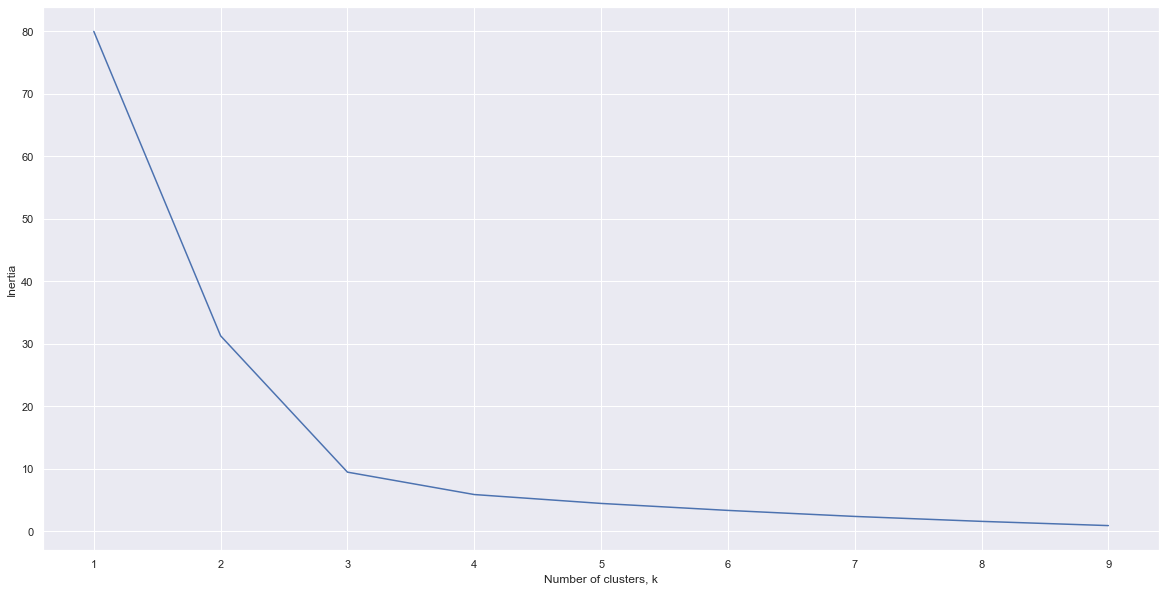

In [8]:
range_of_clusters = range(1, 10)
inertia_by_n_clusters = []

for n_clusters in range_of_clusters:
    # set the number of clusters
    pipeline['k_means'].n_clusters = n_clusters

    # fit the pipeline to the data
    pipeline.fit(X_train)
    inertia_by_n_clusters.append(pipeline['k_means'].inertia_)

# plot inertia as a function of the number of clusters
plt.plot(range_of_clusters, inertia_by_n_clusters)
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.show()

We will choose an "elbow" point in the inertia plot. For this dataset it appears `n_clusters=3` is a good choice which corresponds nicely to the following inferred categories:

1. Short Range Aircraft
2. Medium Range Aircraft
3. Long Range Aircraft

### Train Optimized Model

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('k_means', KMeans(n_clusters=3))
])

# fit pipeline to training data
pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('k_means', KMeans(n_clusters=3))])

In [10]:
# predict labels for training data
labels = pipeline.predict(X_train)
labels

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2], dtype=int32)

We can now visualize our model's predictions on the training data. The grouping are as follows:

**Long Range**
* Boeing 777-300ER
* Boeing 777-200LR
* Airbus A330-300
* Boeing 787-9
* Boeing 787-8
* Boeing 767-300ER

**Medium Range**
* Airbus A321-200
* Airbus A320-200
* Airbus A319-100
* Embraer 190
* Embraer 175
* Bombardier CRJ900
* Bombardier CRJ100/200

**Short Range**
* Bombardier Q400
* Bombardier Dash 8-300
* Bombardier Dash 8-100

In [11]:
# group aircraft models by predicted label
fleet_df['Category'] = labels
fleet_df.sort_values(by='Category')

,Model,Identifier,Cruise Speed (km/h),Range (km),Cruise Altitude (m),Cargo Capacity (kg),Total Seats,Category
6,Airbus A321-200,321,837,4350,10668,3600,190,0
7,Airbus A320-200,320,837,4442,10668,2000,146,0
8,Airbus A319-100,319,837,4442,10668,2000,120,0
9,Embraer 190,E90,811,3540,10668,1502,97,0
10,Embraer 175,E75,811,2413,10668,600,76,0
11,Bombardier CRJ900,CR9,881,2778,11887,2134,76,0
13,Bombardier CRJ100/200,CRJ,860,1825,10668,1591,50,0
0,Boeing 777-300ER,77W,896,14594,10668,23024,450,1
1,Boeing 777-200LR,77L,896,17446,10668,15300,300,1
2,Airbus A330-300,333,869,10560,11277,13900,292,1


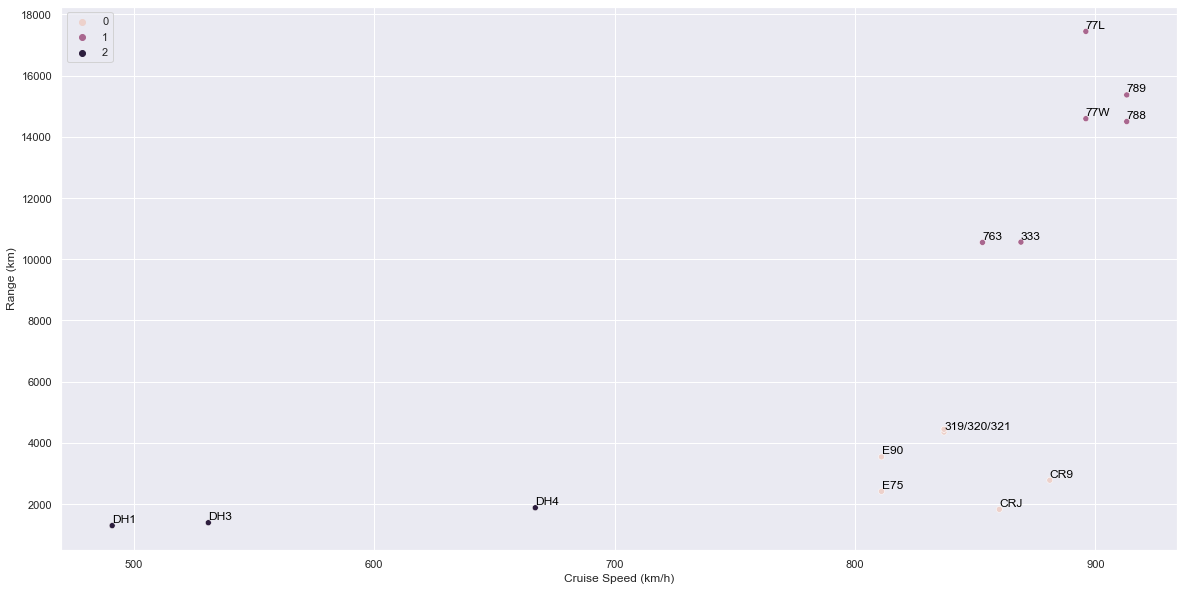

In [12]:
# visualize clusters on a plot of speed versus range
p1 = sns.scatterplot(x='Cruise Speed (km/h)', y='Range (km)', hue='Category', data=fleet_df)

label_offset = 100 # km
for idx in range(fleet_df.shape[0]):
    # skip A320 family labels since they are close proximity
    if fleet_df['Identifier'][idx] in ['319', '320']:
        continue
    
    label = fleet_df['Identifier'][idx]
    p1.text(
        fleet_df['Cruise Speed (km/h)'][idx],
        fleet_df['Range (km)'][idx] + label_offset,
        label if label != '321' else '319/320/321',
        horizontalalignment='left',
        size='medium',
        color='black'
    )

plt.legend(loc='upper left')
plt.show()

## Making New Predictions
To further evaluate the quality of the clustering model we will predict the class of the Airbus A350-1000, a modern long-haul aircraft

In [13]:
a350_1000_specs = {
    'Cruise Speed (km/h)': 903,
    'Range (km)': 16100,
    'Cruise Altitude (m)': 11277,
    'Cargo Capacity (kg)': 25000,
    'Total Seats': 410
}

# predict A350-1000 class
a350_1000_features = np.array(list(a350_1000_specs.values())).reshape(1, -1)
pipeline.predict(a350_1000_features)

array([1], dtype=int32)

The model has correctly classified this aircraft as belonging to the long-haul family (along with its competition the Boeing 787)

## Save Model

In [14]:
with open('fleet_clustering_model.p', 'wb') as f:
    pickle.dump(pipeline, f)

In [15]:
# save dictionary mapping aircraft identifiers to category
identifiers_and_cat = fleet_df[['Identifier', 'Category']].to_numpy()
identifier_to_cat = {x[0]: x[1] for x in identifiers_and_cat}
display(identifier_to_cat)

with open('identifiers_to_cat.p', 'wb') as f:
    pickle.dump(identifier_to_cat, f)

{'77W': 1,
 '77L': 1,
 '333': 1,
 '789': 1,
 '788': 1,
 '763': 1,
 '321': 0,
 '320': 0,
 '319': 0,
 'E90': 0,
 'E75': 0,
 'CR9': 0,
 'DH4': 2,
 'CRJ': 0,
 'DH3': 2,
 'DH1': 2}